In [1]:
import matplotlib.pyplot as plt
import pycircstat as pycircstat
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
from openpyxl import load_workbook
from matplotlib import rcParams
rcParams['font.sans-serif']=["arial"]

In [2]:
#Opening pickled dictionary
import time
import pickle
start_time = time.time()

pictable_humancells_pd = "../data/pickletable_HumanCells_pd"

#open the file for reading
open_humancells_obj_pd = open(pictable_humancells_pd, 'rb')

#load the object from the file into new_table_PC
all_PCs = pickle.load(open_humancells_obj_pd)

print("Done")
print("This code took", "%.2f"%(time.time() - start_time), "seconds to run.")

Done
('This code took', '0.25', 'seconds to run.')


# Working with Subthreshold data
Now we need to select the subthreshold experiments. In those experiment, there is no spiking, the intracellular amplitude is zero, and the extracellular amplitude is non-zero. We put this new subset of data into a new table called subt_PCs

In [3]:
subt_PCs = all_PCs[(all_PCs['in_amp_pA']==0) & (all_PCs['ex_amp_nA']!=0) & (all_PCs['num_spikes']==0)]

Quick check: For all the suthreshold analysis, the ex_dur must be 9s and ex_delay must be 1s. So the outcome of the following must be TRUE.

In [4]:
print (sum((subt_PCs ['ex_dur_ms']==9000) & (subt_PCs ['ex_delay_ms']==1000)) == len(subt_PCs))

True


concatenate all subthreshold data together for this part of analysis

In [5]:
allsubth = pd.concat([subt_PCs])

In [6]:
def fit_one_over_distance_function(d, data):
    from scipy.optimize import leastsq
#    d = d * 1000
    guess_pho = 1
    optimize_func = lambda pho: 1/(pho * d) - data
    est_pho = leastsq(optimize_func, [guess_pho])[0]
    data_fit = 1/(est_pho * d)
    return est_pho, data_fit

def find_derivative_of_fitted_curve_at_d(d, est_pho):
    return (1. )/(est_pho * pow(d,2)) * 1000

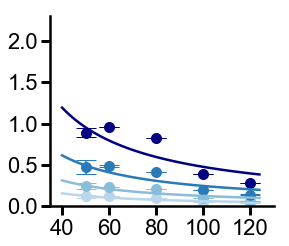

In [7]:
from matplotlib import rcParams
rcParams['font.sans-serif']=["arial"]
plt.figure(figsize=(4,3.5))
ax = plt.subplot(111)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=9, width=3)
z = allsubth[(allsubth['ex_el_distance_mu']<130) & (allsubth['ex_frequency']==8)]
color = ['#BAD6EBFF', '#88bddcff', '#2a7ab9ff', '#000080ff']
i = 0
for (amp), g in z.groupby(['ex_amp_nA']):
    df= g[['ex_el_distance_mu', 'vext_amp_mV']]
    df = df.sort_values(['ex_el_distance_mu'])
    est_pho, data_fit = fit_one_over_distance_function(df['ex_el_distance_mu'], df['vext_amp_mV'])
    plt.plot(np.arange(40,125), (1./(est_pho * np.arange(40,125))), lw=2.5, color=color[i])
    d_list = []
    mean_list = []
    std_list = []
    for d, gg in g.groupby(['ex_el_distance_mu']):
        d_list = d_list + [d]
        mean_list = mean_list + [np.mean(gg['vext_amp_mV'])]
        std_list = std_list + [np.std(gg['vext_amp_mV'])]
    plt.errorbar(d_list, mean_list, std_list, capsize=10, ls='none', color=color[i])
    plt.scatter(d_list, mean_list, label="{} nA".format(amp),s=100, color=color[i])
    i += 1
#plt.xlabel("Distance from ES ($\mu$m)", size=20, labelpad=7)
#plt.ylabel("Extracellular Voltage (mV)", size=20, labelpad=7)
#plt.legend(fontsize=13, loc=(0.6,0.6), frameon=False, handletextpad=0.2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(35,130)
plt.ylim(0, 2.3)
#plt.savefig("fig_dis.svg", transparent="True")
plt.show()

In [8]:
everything = all_PCs

In [9]:
def plot_fig_fields(everything, freq, amp, addcolor):
    import matplotlib.ticker as mtick
    Ve_list = []
    E_list = []

#turn everything-df into dictionary with filename as key, and small-df as value   
    list_of_filenames = everything["filename"].unique()
    bigdict = {}
    for x in list_of_filenames:
        minidf = everything.groupby(["filename"]).get_group(x)    
        bigdict[x]=minidf       

    for k,v in bigdict.iteritems():
        subth = v
        subth = subth[(subth['in_amp_pA']==0) & (subth['ex_amp_nA']!=0) & (subth['num_spikes']==0) & (subth['ex_el_distance_mu']<130) & (subth['ex_frequency']==freq) & (subth['ex_amp_nA']==amp)]        
        for amp, g in subth.groupby(['ex_amp_nA']):
            df= g[['ex_el_distance_mu', 'vext_amp_mV']]
            df = df.sort_values(['ex_el_distance_mu'])
            est_pho, data_fit = fit_one_over_distance_function(df['ex_el_distance_mu'], df['vext_amp_mV'])  
            soma_dist = 50
            E_list = E_list + [find_derivative_of_fitted_curve_at_d(soma_dist , est_pho)[0]]
            Ve_list = Ve_list + [np.mean(df[df['ex_el_distance_mu']==soma_dist]['vext_amp_mV'])]    
    plt.scatter(E_list, Ve_list, s=150, color=addcolor)
    ax = plt.gca()
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(length=11, width=5, labelsize=20)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
#     ax.set_xlabel("Electric field (mV/mm)", fontsize=20, weight='medium') 
#     ax.set_ylabel("Ve amplitude (mV)", fontsize=20, weight='medium')
    plt.scatter(np.median(E_list), np.median(Ve_list), s=300, color='black')
    plt.errorbar(np.median(E_list), np.median(Ve_list), yerr=np.std(Ve_list), xerr=np.std(E_list), elinewidth=3, color='black')
#     plt.tight_layout()
    print "Ve ± std: " "%.1f"%(np.median(Ve_list)),"±", "%.1f"%(np.std(Ve_list)), "mV"
    print "Efield ± std: " "%.1f"%(np.median(E_list)),"±", "%.1f"%(np.std(E_list)), "mV/mm"
    return plt

Ve ± std: 0.1 ± 0.0 mV
Efield ± std: 2.4 ± 0.4 mV/mm


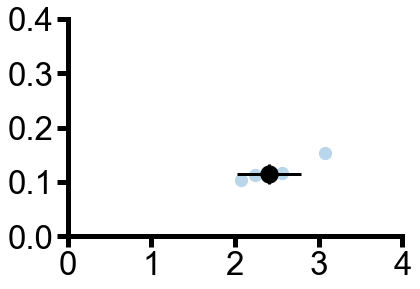

Ve ± std: 0.2 ± 0.0 mV
Efield ± std: 4.8 ± 0.8 mV/mm


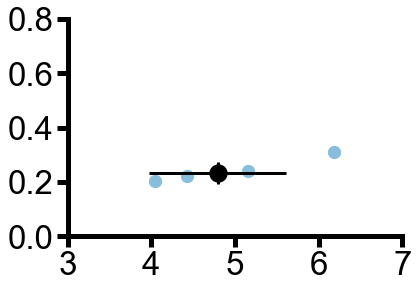

Ve ± std: 0.4 ± 0.1 mV
Efield ± std: 8.9 ± 1.7 mV/mm


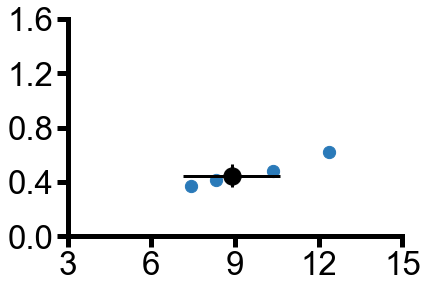

Ve ± std: 0.9 ± 0.1 mV
Efield ± std: 17.6 ± 1.7 mV/mm


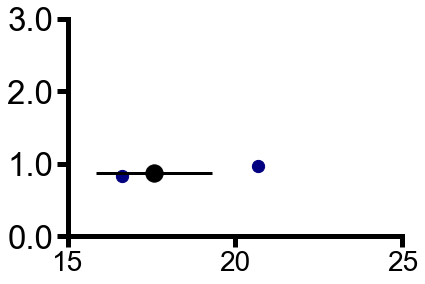

In [10]:
plot_fig_fields(everything, 8, 25, '#BAD6EBFF')
# plt.title("I={} nA, Freq={} Hz".format(25, 1), size=20, weight="bold")
plt.xticks(range(0,5,1), fontsize=33, fontname = "Arial")
# plt.xticks(fontsize=20)
plt.yticks([0, 0.1,0.2,0.3, 0.4],fontsize=33, fontname = "Arial")
#plt.savefig("C:/Users/PCUser/V1_Efield_25nA_8Hz.svg", transparent="true")
plt.show()

plot_fig_fields(everything, 8, 50, '#88bddcff')
#plt.title("I={} nA, Freq={} Hz".format(50, 1), size=20, weight="bold")
plt.xticks(range(3,8,1),fontsize=33, fontname = "Arial")
# plt.yticks([0.1,0.3,0.5, 0.7, 0.9],fontsize=20)
plt.yticks([0,0.2,0.4, 0.6, 0.8],fontsize=33, fontname = "Arial")
#plt.savefig("C:/Users/PCUser/V1_Efield_50nA_8Hz.svg", transparent="true")
plt.show()

plot_fig_fields(everything,8, 100, '#2a7ab9ff')
#plt.title("I={} nA, Freq={} Hz".format(100, 1), size=20, weight="bold")
plt.xticks([3,6,9,12,15],fontsize=33, fontname = "Arial")
plt.yticks([0, 0.4, 0.8, 1.2, 1.6],fontsize=33, fontname = "Arial")
#plt.savefig("C:/Users/PCUser/V1_Efield_100nA_8Hz.svg", transparent="true")
plt.show()

plot_fig_fields(everything, 8, 200, '#000080ff')
#plt.title("I={} nA, Freq={} Hz".format(200, 1), size=20, weight="bold")
plt.xticks(range(15,30,5),fontsize=28, fontname = "Arial")
plt.yticks([0, 1.0, 2.0, 3.0],fontsize=33, fontname = "Arial")
#plt.savefig("C:/Users/PCUser/V1_Efield_200nA_8Hz.svg", transparent="true")
plt.show()

We need to use this table to generate Subthreshold entrainment plots. First we will group the data based on extracellular_electrode_distance, extracellular amplitude and frequency. Meaning that all the experiments with the same dextracellular amplitude, freq and distance of the electrode will be in the same group. Then we will compute the mean and std of the Vi, Vext and Vm amplitude and phase in each group. Then we plot these mean and std values as a function of frequencies. The function bellow, takes the subt_PCs and subt_Pvalbs and returns another table which has all the mean and std values for each group of data.

In [11]:
def generate_subthreshold_data(table):
    subt_data = pd.DataFrame(columns=['ex_frequency', 'ex_amp_nA', 'ex_el_distance_mu',
                                      'mean_vi_amp_mV', 'std_vi_amp', 'mean_vi_phase','std_vi_phase',
                                      'mean_vm_amp_mV', 'std_vm_amp', 'mean_vm_phase','std_vm_phase',
                                      'mean_vext_amp_mV', 'std_vext_amp', 'mean_vext_phase', 'std_vext_phase'])

    for (freq,ex_amp, distance),g in table.groupby(['ex_frequency', 'ex_amp_nA', 'ex_el_distance_mu']):
        subt_data = subt_data.append({'ex_frequency' : freq,
                                      'ex_el_distance_mu' : distance,
                                      'ex_amp_nA' : ex_amp, 
                                      'mean_vi_amp_mV' : np.mean(g['vi_amp_mV']),
                                      'mean_vi_phase' : np.mean(g['vi_phase']),
                                      'std_vi_amp' : np.std(g['vi_amp_mV']),
                                      'std_vi_phase' : np.std(g['vi_phase']),                                      
                                      'mean_vm_amp_mV' : np.mean(g['vm_amp_mV']),
                                      'mean_vm_phase' : np.mean(g['vm_phase']),
                                      'std_vm_amp' : np.std(g['vm_amp_mV']),                                      
                                      'std_vm_phase' : np.std(g['vm_phase']),
                                      'mean_vext_phase': np.mean(g['vext_phase']),
                                      'mean_vext_amp_mV' : np.mean(g['vext_amp_mV']),
                                      'std_vext_phase': np.std(g['vext_phase']),
                                      'std_vext_amp' : np.std(g['vext_amp_mV'])} ,ignore_index = True)
    return subt_data

### For cells at rest

In [12]:
subt_PCs_data = generate_subthreshold_data(subt_PCs)

In [13]:
# #To get numbers printed out on excel sheet (will overwrite sheet though)
# def getnumrest(restdata, ex_amp, ex_el_distance, folderpath, excelname):
#     restdataappend = restdata[(restdata['ex_amp_nA'] == ex_amp) & (restdata['ex_el_distance_mu']== ex_el_distance)]
#     excelsheetname = folderpath + excelname + ".xlsx"
#     restdataappend.to_excel(excelsheetname)

Now we are going to plot using the subt_PC_data data tables. The following two functions will help us to do so:

In [14]:
def plt_prop(xlabel, ylabel, xlim, ylim):
    from matplotlib import rc, rcParams
    rc('font', weight='medium')
    rc('axes', linewidth=1.5)
    fig, (ax) = plt.subplots(1,1, figsize=(1.5, 1.13))
    ax.set_xlabel(xlabel, fontsize=10, weight='medium') 
    ax.set_ylabel(ylabel, fontsize=10, weight='medium')
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
#    ax.legend(fontsize=20)
    ax.set_xlim(xlim[0], xlim[1]+5)
    ax.set_ylim(ylim[0], ylim[1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.tick_params(length=4,width=1.5, labelsize=9.5)
#     plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    return ax

In [15]:
def plot_subth(data, ex_amp, ex_el_distance, Vi_color, drop_freq_70, var_to_plot = "voltage"):  
    t = data[(data['ex_amp_nA'] == ex_amp) & (data['ex_el_distance_mu']== ex_el_distance)]
    if drop_freq_70:
        ndx70 = t[t['ex_frequency']==70].index[0]
        t = t.drop(ndx70)
    if var_to_plot == "voltage":
        ax = plt_prop("", "", (-3,101), (-0.05,1.2))        
#        ax.set_title(title, size=20, weight="bold")        
        ax.errorbar(t['ex_frequency'],t['mean_vi_amp_mV'], t['std_vi_amp'], capsize=3.75, capthick=1.25, linewidth=1.25, color=Vi_color, label='_nolegend_', zorder=3) #label = "Vi")
        ax.scatter(t['ex_frequency'],t['mean_vi_amp_mV'], color=Vi_color, label = "Vi", s=30, zorder=3)
        ax.errorbar(t['ex_frequency'],t['mean_vext_amp_mV'], t['std_vext_amp'], capsize=3.75, capthick=1.25,linewidth=1.25, color='#808080', label='_nolegend_', zorder=2) #label = "Vext")
        ax.scatter(t['ex_frequency'],t['mean_vext_amp_mV'], color='#808080', label = "Vext", s=30, zorder=2)
        ax.errorbar(t['ex_frequency'],t['mean_vm_amp_mV'], t['std_vm_amp'], capsize=3.75, capthick=1.25,linewidth=1.25, color='#1f77b4', label='_nolegend_') #label = "Vm"
        ax.scatter(t['ex_frequency'],t['mean_vm_amp_mV'],  color='#1f77b4', label = "Vm", s=30)       
        ax.set_xticks([0, 50, 100])
        ax.set_yticks([0, 0.5,1.0]) 
#         plt.legend(fontsize=20, loc=(1,0.7), frameon=False)
#         plt.savefig("")
    else:
#         ax = plt_prop("Frequency (Hz)", "Phase($\degree$)", (-3,101), (-0.05,1.2))
        ax = plt_prop("", "", (-3,101), (-0.05,1.2))
#        ax.set_title(title, size=20, weight="bold")
        ax.errorbar(t['ex_frequency'],t['mean_vi_phase'], t['std_vi_phase'], capsize=3.75, capthick=1.25, color=Vi_color, label='_nolegend_', zorder=3) #label = "Vi")
        ax.scatter(t['ex_frequency'],t['mean_vi_phase'],  color=Vi_color,label = "Vi", s=30, zorder=3)
        ax.errorbar(t['ex_frequency'],t['mean_vext_phase'], t['std_vext_phase'], capsize=3.75, capthick=1.25,linewidth=1.25, color='#808080', label='_nolegend_', zorder=2) #label  = "Vext")
        ax.scatter(t['ex_frequency'],t['mean_vext_phase'], color='#808080',label = "Vext", s=30, zorder=2)
        ax.errorbar(t['ex_frequency'],t['mean_vm_phase'], t['std_vm_phase'], capsize=3.75, capthick=1.25,linewidth=1.25, color='#1f77b4', label='_nolegend_') #label = "Vm
        ax.scatter(t['ex_frequency'],t['mean_vm_phase'],  color='#1f77b4',label = "Vm", s=30)
        ax.set_ylim(-50,370)
        ax.set_yticks([0, 180, 360])
        ax.set_xticks([0, 50, 100])
#         ax.set_yticks([0, 1, 2, 3])
#         plt.savefig("")
#         plt.legend(fontsize=20, loc=(1,0.7), frameon=False)
    return ax

It is important to note that to plot the Vm, we used the electrode at distance == 50 to compute the values.

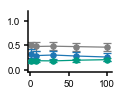

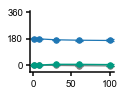

In [16]:
plot_subth(subt_PCs_data, 100, 50,'#009b81', True, "voltage")
plot_subth(subt_PCs_data, 100, 50 , '#009b81', True, "phase")

#plt.savefig("", transparent="True")

### For polarized cells (where we gave + or - intracellular current injection)

The next subthreshold plot is subthreshold entrainment for polarized cells. For that we need to group the data in a different way. First of all, we use the complete tables of the cell classes. Then we subset all the experiments in which the cell is not spiking but intracellular current injection can be nonzero. Note that we compute the Vm for only the electrodes that are close to the cell, so only those values from the table are taken.

In [17]:
subt_PCs_forpolar = all_PCs[(all_PCs['num_spikes']==0) & (all_PCs['ex_el_distance_mu']==50) & (all_PCs['in_amp_pA']<95)]

In [18]:
def generate_subthreshold_data_polar(table):
    subt_data = pd.DataFrame(columns=['vm', 'ex_amp_nA', 'ex_el_distance_mu',
                                      'mean_vi_amp_mV', 'std_vi_amp', 'mean_vi_phase','std_vi_phase',
                                      'mean_vm_amp_mV', 'std_vm_amp', 'mean_vm_phase','std_vm_phase',
                                      'mean_vext_amp_mV', 'std_vext_amp', 'mean_vext_phase', 'std_vext_phase'])

    max_vm = np.round(np.max(table['avg_vm_mV']))
    min_vm = np.round(np.min(table['avg_vm_mV'])-1)
    nbins =7
    interval = (max_vm- min_vm)/ nbins
    bins =  [min_vm + i * interval for i in range(nbins+1)]
    table['temp'] = table.apply(lambda row: np.digitize(row['avg_vm_mV'],bins) , axis=1)
    table['vm'] = table.apply(lambda row: bins[row['temp']-1] + interval/2. , axis=1)
    for (vm,ex_amp, distance, freq),g in table.groupby(['vm', 'ex_amp_nA', 'ex_el_distance_mu', 'ex_frequency']):
        subt_data = subt_data.append({'vm' : vm,
                                      'ex_el_distance_mu' : distance,
                                      'ex_frequency' : freq,
                                      'ex_amp_nA' : ex_amp, 
                                      'mean_vi_amp_mV' : np.mean(g['vi_amp_mV']),
                                      'mean_vi_phase' : np.mean(g['vi_phase']),
                                      'std_vi_amp' : np.std(g['vi_amp_mV']),
                                      'std_vi_phase' : np.std(g['vi_phase']),                                      
                                      'mean_vm_amp_mV' : np.mean(g['vm_amp_mV']),
                                      'mean_vm_phase' : np.mean(g['vm_phase']),
                                      'std_vm_amp' : np.std(g['vm_amp_mV']),                                      
                                      'std_vm_phase' : np.std(g['vm_phase']),
                                      'mean_vext_phase': np.mean(g['vext_phase']),
                                      'mean_vext_amp_mV' : np.mean(g['vext_amp_mV']),
                                      'std_vext_phase': np.std(g['vext_phase']),
                                      'std_vext_amp' : np.std(g['vext_amp_mV'])} ,ignore_index = True)
    return subt_data

In [19]:
pd.options.mode.chained_assignment = None #for now, will set this to none, to ignore warning about .loc

subtPCs_polar_nums = generate_subthreshold_data_polar(subt_PCs_forpolar)

In [20]:
# #To get numbers printed out on excel sheet (will overwrite sheet though)
# def getnum_polar(polardata, ex_amp, ex_frequency, ex_el_distance, folderpath, excelname):
#     polardataappend = polardata[(polardata['ex_amp(nA)'] == ex_amp) & (polardata['ex_frequency']== ex_frequency) & (polardata['ex_el_distance(mu)']== ex_el_distance)]
#     excelsheetname = folderpath + excelname + ".xlsx"
#     polardataappend.to_excel(excelsheetname)

In [21]:
def plot_polar_subth(data, ex_amp, ex_frequency, ex_el_distance, Vi_color, var_to_plot = "voltage", xtickrange=None, xlimrange=None):
    t = data[(data['ex_amp_nA'] == ex_amp) & (data['ex_frequency']== ex_frequency) & (data['ex_el_distance_mu']== ex_el_distance)]   
    if var_to_plot == "voltage":
#        ax = plt_prop(" Vm (mV)", "Amplitude(mV)", xlimrange, (0,1.2))
        ax = plt_prop("", "", xlimrange, (-0.05,1.0))        
#        ax.set_title(title, size=20, weight="bold")
        ax.errorbar(t['vm'],t['mean_vi_amp_mV'], t['std_vi_amp'], capsize=3.75, capthick=1.25, color=Vi_color, linewidth=1.25, label = "Vi", zorder=3) #linewidth=4, 
        ax.scatter(t['vm'],t['mean_vi_amp_mV'], color=Vi_color, label = "Vi", s=30, zorder=3)
        ax.errorbar(t['vm'],t['mean_vext_amp_mV'], t['std_vext_amp'], capsize=3.75, capthick=1.25, color='#808080', linewidth=1.25, label = "Vext", zorder=2)
        ax.scatter(t['vm'],t['mean_vext_amp_mV'],  color='#808080', label = "Vext", s=30, zorder=2)
        ax.errorbar(t['vm'],t['mean_vm_amp_mV'], t['std_vm_amp'], capsize=3.75, capthick=1.25, color='#1f77b4', linewidth=1.25, label = "Vm")
        ax.scatter(t['vm'],t['mean_vm_amp_mV'],  color='#1f77b4', label = "Vm", s=30)
        ax.set_yticks([0, 0.5, 1])
        ax.set_xticks(xtickrange)
#        plt.savefig()
    else:
#        ax = plt_prop(" Vm (mV)", "Phase ($\degree$)", xlimrange, (0,1.5))
        ax = plt_prop("", "", xlimrange, (0,1.5))
        #         ax.set_title(title, size=20, weight="bold")
        ax.errorbar(t['vm'],t['mean_vi_phase'], t['std_vi_phase'], capsize=3.75, capthick=1.25,color=Vi_color, linewidth=1.25, label = "Vi", zorder=3)
        ax.scatter(t['vm'],t['mean_vi_phase'],  color=Vi_color,label = "Vi", s=30, zorder=3)
        ax.errorbar(t['vm'],t['mean_vext_phase'], t['std_vext_phase'], capsize=3.75, capthick=1.25,linewidth=1.25, color='#808080', label = "Vext", zorder=2)
        ax.scatter(t['vm'],t['mean_vext_phase'], color='#808080',label = "Vext", s=30, zorder=2)
        ax.errorbar(t['vm'],t['mean_vm_phase'], t['std_vm_phase'], capsize=3.75, capthick=1.25,linewidth=1.25, color='#1f77b4', label = "Vm")
        ax.scatter(t['vm'],t['mean_vm_phase'], color='#1f77b4',label = "Vm", s=30)     
        ax.set_ylim(-50,370)
        ax.set_yticks([0, 180, 360])
        ax.set_xticks(xtickrange)
#        plt.savefig()
#     plt.legend(fontsize=20)
#     plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    return ax

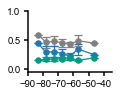

In [22]:
xtickrange=[-90,-80,-70,-60,-50,-40]
xlimrange=(-90, -40)
plot_polar_subth(subtPCs_polar_nums , 100, 8, 50 , '#009b81', "voltage", xtickrange, xlimrange)

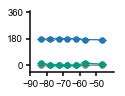

In [23]:
xtickrange_polar=[-90,-80,-70,-60,-50]
xlimrange_polar=(-90, -44)
plot_polar_subth(subtPCs_polar_nums, 100, 8, 50 , '#009b81', "phase", xtickrange_polar, xlimrange_polar)

# Working with Suprathreshold data

## When ES is present (i.e. non-zero)
First we should select a subset from the table for which the cell is spiking after 3.5s becasue we are only analyzing spikes after that. Moreover we dont want to analyze the control sweeps now, so we took only the sweeps that have ex_amp(nA)!=0 

In [24]:
# when there is ES (ES is non-zero)
supra_PCs = all_PCs[(all_PCs['num_spikes_A']>0) & (all_PCs['ex_amp_nA']!=0) & (all_PCs['ex_dur_ms']==13000) & (all_PCs['ex_el_distance_mu']==50)]

Before going ahead, we will add firing rate for each row to our table. 

In [25]:
pd.options.mode.chained_assignment = None #for now, will set this to none, to ignore warning

supra_PCs['firing_rate_only_when_spiking'] = supra_PCs.apply(lambda row: row['num_spikes_A'] / ((row['spike_tt_A'][-1] - row['spike_tt_A'][0])/1000.), axis=1)

Here we write couple of functions to group the supra tables as the following: first we group the supra table by the frequency and extracellular amplitude. Then we gather all the corrected spike phases and use pycircstat package to compute the p_value, vector length, vector angle and ... and return a table with all these values. 

In [26]:
def return_rose_data(table, ISI=False, n_sample=None):
    import random
    data = pd.DataFrame(columns=['ex_frequency', 'ex_amp_nA', 'p_value', 'v_l', 'v_l_std', 'total_n_spikes', 
                                 'mean_firing_rate', 'std_firing_rate', 'v_angle', 'all_spike_phases'])
    
    for (freq,ex_amp),g in table.groupby(['ex_frequency', 'ex_amp_nA']):
        if ISI:
            list1 = g['spike_phase_A_corrected'].sum()
            list2 = g['spike_ISI'].sum()
            ndx= [list2.index(x) for x in list2 if (x>freq - 1.5) & (x<freq + 1.5)]
            all_spike_phases = [list1[x] for x in ndx]
        else:
            all_spike_phases = g['spike_phase_A_corrected'].sum()
        if n_sample: all_spike_phases = random.sample(all_spike_phases, n_sample)
        total_n_spikes = len(all_spike_phases)
        if (len(all_spike_phases) != 0):
            v_angle = pycircstat.descriptive.mean(np.array(all_spike_phases))
            v_angle_std = pycircstat.descriptive.std(np.array(all_spike_phases))
            v_length = pycircstat.descriptive.vector_strength(np.array(all_spike_phases)) 
            p_value = pycircstat.rayleigh(np.array(all_spike_phases))[0]
            data = data.append({'ex_frequency' : freq,
                                'firing_rate_only_when_spiking': np.mean(g['firing_rate_only_when_spiking']),
                                'firing_rate_only_when_spiking': np.std(g['firing_rate_only_when_spiking']),
                                'all_spike_phases': all_spike_phases,
                                'ex_amp_nA' : ex_amp, 
                                'p_value': p_value,
                                'v_l': v_length,
                                'v_l_std': pycircstat.descriptive.std(np.array(all_spike_phases)),
                                'total_n_spikes': len(all_spike_phases),
                                'v_angle': v_angle * 180 / np.pi,
                                'v_angle': v_angle_std * 180 / np.pi} ,ignore_index = True)
    return data

In [27]:
#plotting is normalized to radius 1 
def plot_polar_histogram_grid(rose_data, amp_list , fq_list, m=None,n_sample=None, barcolor=None):
    import random
    
    fig, axs = plt.subplots(len(fq_list), len(amp_list), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))    
    fig.subplots_adjust(wspace=0.15,hspace=0.08, top=1.5)
    if len(fq_list) or len(amp_list) > 1:
        axs = axs.ravel()
    maxnum=[]
    Number_of_spikes=[]
    Vector_Length=[]
    Vector_Angle=[]
    Vector_Angle_STD = []
    p_values=[]
    kappas = []
    for i, (fq,amp) in enumerate([[fq,amp] for fq in fq_list for amp in amp_list]):
        t = rose_data[(rose_data['ex_amp_nA']==amp) & (rose_data['ex_frequency']==fq)]
        all_spikes = t['all_spike_phases'].sum()
        if len(all_spikes) == 0:
            print 'There were no spikes at amplitude {} and frequency {}.'.format(amp, fq)
            continue
        if n_sample: all_spikes = random.sample(all_spikes, n_sample)
        total_n_spikes = len(all_spikes)
        v_angle = pycircstat.descriptive.mean(np.array(all_spikes))
        v_angle_std = pycircstat.descriptive.std(np.array(all_spikes))
        v_length = pycircstat.descriptive.vector_strength(np.array(all_spikes))
        p_value = pycircstat.tests.rayleigh(np.array(all_spikes))[0]  #[1] is z-value
        kap = pycircstat.distributions.kappa(np.array(all_spikes))
        Y, X = np.histogram([x * 180./np.pi for x in all_spikes], bins=15)
        Xp =(X[1:] + X[:-1]) / 2
        Xp = Xp * np.pi / 180
        normY = np.true_divide(Y, (np.max(Y)))
        bars = axs[i].bar(Xp, (normY*0.9),  width=0.4,color=barcolor, edgecolor="black", linewidth=0.7)
        axs[i].set_axisbelow(True)
        thetaticks = np.arange(0,360,90)
        plt.setp(axs[i].spines.values(), linewidth=1.4)
        axs[i].set_thetagrids(thetaticks, labels=[])
        axs[i].set_yticks([0.5])
        axs[i].set_yticklabels([])
        axs[i].grid(color='lightgray',linewidth=0.5) 
        axs[i].set_ylim(0, 1)
        axs[i].annotate('',xy=(v_angle, v_length), xytext=(v_angle,0), xycoords='data', arrowprops=dict(width=1.7,headlength=0.1,headwidth=0.1, color='black') )
        axs[i].set_xlabel('Frequency: {}  amplitude: {}\nTotal number of Spikes: {}\nVector length: {:0.3f}\nVector angle: {:0.2f}\nP-value: {:0.3E}'.format(fq, amp, total_n_spikes, v_length, v_angle * 180./np.pi, p_value), size=10, labelpad = 15)        #nP-value: {:0.3E}
#        axs[i].set_ylabel('# of Spikes: {}\nVectL:{:0.2f}\nVectA:{:0.2f}\nPval:{:0.3E}'.format(total_n_spikes, v_length, v_angle * 180./np.pi, p_value), size=8, labelpad = 5)        #nP-value: {:0.3E}
        Number_of_spikes.append(total_n_spikes)    
        Vector_Length.append(v_length)
        Vector_Angle.append(v_angle * 180./np.pi)   
        Vector_Angle_STD.append(v_angle_std  * 180./np.pi )
        p_values.append(p_value)
        kappas.append(kap)
    return axs, Number_of_spikes, Vector_Length, Vector_Angle, Vector_Angle_STD, p_values, kappas

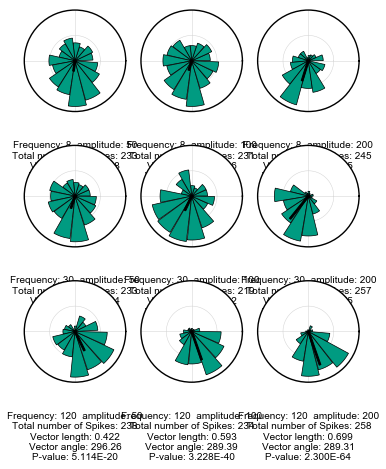

In [28]:
#colors: PCs: #009b81, Pvalbs: #cd3449, SSTs: #fe7f11
#Main figures plot ex_amps 50, 100, 200 nA. Supp. figs have 25 nA data plotted, and it's in the dataframe
#note, for human cells we have 100Hz+, which is noted as 120Hz for analysis purposes
ex_amps_used = [50, 100, 200] #or ex_amps_used = [25, 50, 100, 200]
freq_used = [8, 30, 120]

axs, Number_of_spikes, Vector_Length, Vector_Angle, Vector_Angle_STD, p_values, kappas = plot_polar_histogram_grid(return_rose_data(supra_PCs, ISI=False), ex_amps_used , freq_used, barcolor="#009b81")
plt.show()

## Control data: when ES is zero
First we should select a subset from the table for which the cell is spiking after 3.5s becasue we are only analyzing spikes after that. Moreover we dont want to analyze the control sweeps now, so we took only the sweeps that have ex_amp(nA)!=0 

In [29]:
#control data (no ES, i.e. ES is zero)
control_supra_PCs = all_PCs[(all_PCs['num_spikes_A']>0) & (all_PCs['ex_amp_nA']==0) & (all_PCs['ex_dur_ms']==13000) & (all_PCs['ex_el_distance_mu']==50)]

In [30]:
pd.options.mode.chained_assignment = None #for now, will set this to none, to ignore warning

control_supra_PCs['firing_rate_only_when_spiking'] = control_supra_PCs.apply(lambda row: row['num_spikes_A'] / ((row['spike_tt_A'][-1] - row['spike_tt_A'][0])/1000.), axis=1)

Using the same functions as above, except doesn't have the for-loops because we are looking at 0 nA and 0 Hz (i.e. not [8, 30, 140 Hz]). so for easier plotting purposes, it plots one rose plot instead of a bunch.

In [31]:
def return_rose_data_include_justone(table, ISI=False, n_sample=None, theonefreq=None):
    import random
    data = pd.DataFrame(columns=['ex_frequency', 'ex_amp_nA', 'p_value', 'v_l', 'v_l_std', 'total_n_spikes', 
                                 'mean_firing_rate', 'std_firing_rate', 'v_angle', 'all_spike_phases'])
    
    for (freq,ex_amp),g in table.groupby(['ex_frequency', 'ex_amp_nA']):
        if ISI:
            list1 = g['spike_phase_A_corrected'].sum()
            list2 = g['spike_ISI'].sum()
            ndx= [list2.index(x) for x in list2 if round(x)==theonefreq]
            all_spike_phases = [list1[x] for x in ndx]
        else:
            all_spike_phases = g['spike_phase_A_corrected'].sum()
        if n_sample: all_spike_phases = random.sample(all_spike_phases, n_sample)
        total_n_spikes = len(all_spike_phases)
        if (len(all_spike_phases) != 0):
            v_angle = pycircstat.descriptive.mean(np.array(all_spike_phases))
            v_length = pycircstat.descriptive.vector_strength(np.array(all_spike_phases)) 
            p_value = pycircstat.rayleigh(np.array(all_spike_phases))[0]
            data = data.append({'ex_frequency' : freq,
                                'firing_rate_only_when_spiking': np.mean(g['firing_rate_only_when_spiking']),
                                'firing_rate_only_when_spiking': np.std(g['firing_rate_only_when_spiking']),
                                'all_spike_phases': all_spike_phases,
                                'ex_amp_nA' : ex_amp, 
                                'p_value': p_value,
                                'v_l': v_length,
                                'v_l_std': pycircstat.descriptive.std(np.array(all_spike_phases)),
                                'total_n_spikes': len(all_spike_phases),
                                'v_angle': v_angle * 180 / np.pi} ,ignore_index = True)
    return data

In [32]:
def plot_polar_histogram_grid_just_oneplot(rose_data, amp_list , fq_list, m=None,n_sample=None, barcolor=None, label=None):
    import random
    fig, axs = plt.subplots(1, 1, facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
    fig.subplots_adjust(wspace=0.15,hspace=0.08)
    maxnum=[]
    Number_of_spikes=[]
    Vector_Length=[]
    Vector_Angle=[]
    Vector_Angle_STD=[]
    p_values=[]       
    kappas=[]
    t = rose_data[(rose_data['ex_amp_nA']==amp_list[0]) & (rose_data['ex_frequency']==fq_list[0])]
    all_spikes = t['all_spike_phases'].sum()
    if n_sample: all_spikes = random.sample(all_spikes, n_sample)
    total_n_spikes = len(all_spikes)    
    if not all_spikes:
        total_n_spikes = 0
        v_length = 0
        v_angle = 0
        Vector_Angle = 0
        p_value = 0
        print 'There were no spikes at amplitude {} and frequency {}.'.format(amp_list[0],fq_list[0])
    else:
        total_n_spikes = len(all_spikes)
        v_angle = pycircstat.descriptive.mean(np.array(all_spikes))
        v_angle_std = pycircstat.descriptive.std(np.array(all_spikes))
        v_length = pycircstat.descriptive.vector_strength(np.array(all_spikes))
        p_value = pycircstat.tests.rayleigh(np.array(all_spikes))[0]
        kap=pycircstat.distributions.kappa(np.array(all_spikes))[0]
        Y, X = np.histogram([x * 180./np.pi for x in all_spikes], bins=15)
        Xp =(X[1:] + X[:-1]) / 2
        Xp = Xp * np.pi / 180
        total_spikes = len(all_spikes)
        normY = np.true_divide(Y, (np.max(Y)))
        bars = axs.bar(Xp, (normY*0.9),  width=0.4,color=barcolor, edgecolor="black", linewidth=1.2)
        axs.set_axisbelow(True)
        thetaticks = np.arange(0,360,90)
        plt.setp(axs.spines.values(), linewidth=3)
        axs.set_thetagrids(thetaticks, labels=[])
        axs.set_yticks([0.5])
        axs.set_yticklabels([])
        axs.grid(color='lightgray',linewidth=1.5) 
        axs.set_ylim(0, 1)    
        axs.annotate('',xy=(v_angle, v_length), xytext=(v_angle,0), xycoords='data', arrowprops=dict(width=1.7,headlength=0.1,headwidth=0.1, color='black') )
        if label: axs.set_xlabel('amplitude: {}\nTotal number of Spikes: {}\nVector length: {:0.3f}\nVector angle: {:0.2f}\nP-value: {:0.3E}'.format(amp_list[0], total_n_spikes, v_length, v_angle * 180./np.pi, p_value), size=10, labelpad = 15)        #nP-value: {:0.3E}
        Number_of_spikes.append(total_n_spikes)    
        Vector_Length.append(v_length)
        Vector_Angle.append(v_angle * 180./np.pi)   
        Vector_Angle_STD.append(v_angle_std  * 180./np.pi )
        p_values.append(p_value)
        kappas.append(kap)
    return axs, Number_of_spikes, Vector_Length, Vector_Angle, Vector_Angle_STD, p_values, kappas

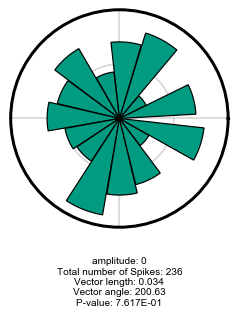

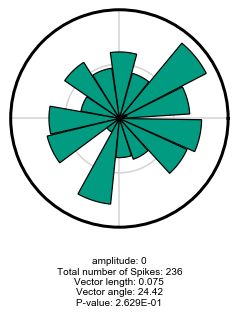

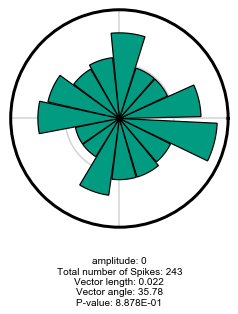

In [33]:
#colors: PCs: #009b81, Pvalbs: #cd3449, SSTs: #fe7f11
axs, Number_of_spikes, Vector_Length, Vector_Angle, Vector_Angle_STD, p_values, kappas = plot_polar_histogram_grid_just_oneplot(return_rose_data_include_justone(control_supra_PCs),  [0] , [8], barcolor="#009b81",n_sample=236, label=True)
axs, Number_of_spikes, Vector_Length, Vector_Angle, Vector_Angle_STD, p_values, kappas = plot_polar_histogram_grid_just_oneplot(return_rose_data_include_justone(control_supra_PCs),  [0] , [30], barcolor="#009b81",n_sample=236, label=True)
axs, Number_of_spikes, Vector_Length, Vector_Angle, Vector_Angle_STD, p_values, kappas = plot_polar_histogram_grid_just_oneplot(return_rose_data_include_justone(control_supra_PCs),  [0] , [120], barcolor="#009b81",n_sample=243, label=True)

# instantaneous spike rate distribution 

In [34]:
pd.options.mode.chained_assignment = None #for now, will set this to none, to ignore warning

supra_PCs['spike_ISI'] = supra_PCs.apply( lambda row: [1000./ (x-y) for x,y in zip(row['spike_tt_A'][1:], row['spike_tt_A'])], axis=1)
supra_PCs['spike_ISI'] = supra_PCs.apply(lambda row: row['spike_ISI'], axis=1)

In [35]:
pd.options.mode.chained_assignment = None #for now, will set this to none, to ignore warning

supra_PCs['mean_ISI'] = supra_PCs.apply(lambda row: np.mean(row['spike_ISI']), axis=1)
supra_PCs['median_ISI'] = supra_PCs.apply(lambda row: np.median(row['spike_ISI']), axis=1)

PC_ISI_mean = np.mean(supra_PCs['mean_ISI'])
PC_ISI_median = np.nanmedian(supra_PCs['median_ISI'])
PC_ISI_std = np.std(supra_PCs['mean_ISI'])
print "V1PC firing rate from ISI (mean): "+ "%.2f"%PC_ISI_mean, u"\u00B1", "%.1f"%PC_ISI_std + "Hz"
print "V1PC firing rate from ISI (median): "+ "%.2f"%PC_ISI_median + "\n"

# First quartile (Q1)
Qu1 = np.percentile(supra_PCs['median_ISI'], 25, interpolation = 'midpoint')
# Third quartile (Q3)
Qu3 = np.percentile(supra_PCs['median_ISI'], 75, interpolation = 'midpoint') 
# Interquaritle range (IQR)
IQR = Qu3 - Qu1

V1PC firing rate from ISI (mean): 7.42 ± 1.1Hz
V1PC firing rate from ISI (median): 6.96



In [36]:
#This gives the histogram

def spike_histo(whichspikes, addcolor, rmin, rmax, xlim_param):
    hist, bins = np.histogram(whichspikes.sum(), bins=10, range=(rmin, rmax))
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.xticks([0,10,20], fontsize=25)
    plt.yticks([0,1000,2000], fontsize=25)
    plt.xlim(xlim_param)
    ax = plt.gca()
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(length=5, width=2, labelsize=20)
    ax.set_xlabel("instantaneous firing rate (Hz)", fontsize=20, weight='medium') 
    ax.set_ylabel("# of spikes", fontsize=20, weight='medium')
    # ax.set_title("Each Pvalb spike's\n firing rate (from ISI)", size=20, weight="bold", y=1.10)
    plt.bar(center, hist, align='center', width=width, color = addcolor)
    plt.show()
    plt.tight_layout()

#plt.savefig("spike_histo.svg", transparent=True)
#return plt

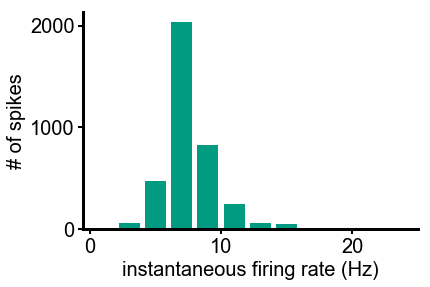

<Figure size 432x288 with 0 Axes>

In [37]:
whichspikes_PCs = supra_PCs['spike_ISI']
addcolor_PCs = "#009b81"
whichrange_PCs_min = 0
whichrange_PCs_max = 20
xlim_param_PCs = (-0.5,25)

spike_histo(whichspikes_PCs, addcolor_PCs, whichrange_PCs_min, whichrange_PCs_max, xlim_param_PCs)